In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-multilearn==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.1 MB/s eta 0:00:00


In [ ]:
# import tensorflow as tf

# # Disable GPU (if available)
# tf.config.set_visible_devices([], 'GPU')

# # Or, you can specify the CPU device explicitly
# # tf.config.set_visible_devices([], 'GPU:0')

# # Now TensorFlow will use only the CPU

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix
import os

In [ ]:
d2= pd.read_csv('/content/drive/MyDrive/HateSpeech/Tracks Participated/ICON 2023/English/train_en_l1 - train_en_l1.csv')
d2
# d2 = d2.rename(columns={'image_name' : 'unique_id', 'sentence' : 'text'})
# d2.to_csv('/content/drive/MyDrive/Colab Notebooks/MULTILATE/train_val.csv', index=False)
# d2

,text,key,en_a1,en_a2,en_a3,en_a4,en_a5,en_a6,label
0,"This is our history . For Shia and Sunni ,...",question_1,NaN,NaN,NaN,NaN,NaN,0.0,0
1,"If this is ""grilling"" then wht wud u call t...",question_1,NaN,NaN,NaN,1,NaN,NaN,1
2,look at <handle replaced>madam. Locals attacke...,question_1,NaN,NaN,NaN,NaN,0.0,NaN,0
3,our beloved yogi ji has given money home and f...,question_1,NaN,NaN,NaN,NaN,1.0,NaN,1
4,"""I gonna kill that bitch"" Bitvj imma kill you...",question_1,NaN,NaN,NaN,NaN,NaN,1.0,1
...,...,...,...,...,...,...,...,...,...
6526,“mama let’s research” bitch suck my dick 😭,question_1,NaN,NaN,NaN,NaN,0.0,NaN,0
6527,😂😂😂😂 I WAS BY MYSELF AND IT WAS HER AND HER BI...,question_1,NaN,NaN,NaN,NaN,0.0,NaN,0
6528,😂😂😂😂😂😂😂😂😂 i just seen a comment and bitch IM C...,question_1,NaN,NaN,NaN,NaN,0.0,NaN,0
6529,"😎""Boys Only Luxury!!!!!!!!!!!!!!!!!!!!!!!!!!!""...",question_1,0.0,1,1,0,NaN,NaN,1


The label column is created in the original training dataset by taking the majority occurence of 0 or 1 among all the 6 annotators in columns - 'en_a1',
 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6'.

In [ ]:
# # Function to determine binary_label
# def determine_binary_label(label):
#     if 'sexist' in label.lower() or 'racist' in label.lower():
#         return 'hate'
#     else:
#         return 'not_hate'

# # Apply the function to create the new column
# d2['binary_label'] = d2['label'].apply(determine_binary_label)

# # Switch the positions of 'binary_label' and 'label' columns
# # df1 = df1[['binary_label', 'label'] + [col for col in df1.columns if col not in ['label', 'binary_label']]]
# d2 = d2[['unique_id', 'text', 'binary_label', 'label']]
# d2

In [ ]:
# d2.to_csv('/content/drive/MyDrive/Colab Notebooks/MULTILATE/train_val.csv', index=False)

## Word Pre-Processing

In [ ]:
## Word Pre-Processing ##
import nltk
nltk.download('stopwords')
import string
import re
wpt = nltk.WordPunctTokenizer()
stop_words_init = nltk.corpus.stopwords.words('english')
stop_words = [i for i in stop_words_init if i not in ('not','and','for')]
print(stop_words)
## Function to normalize text for pre-processing ##
def normalize_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text
## Apply the written function ##
d2['text'] = d2['text'].apply(lambda x: normalize_text(x))
processed_list = []
for j in d2['text']:
    process = j.replace('...','')
    processed_list.append(process)

df_processed = pd.DataFrame(processed_list)
df_processed.columns = ['text']
df_processed.head(n=5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't

,text
0,this is our history for shia and sunni ...
1,if this is grilling then wht wud u call t...
2,look at madam locals attacked no religion a...
3,our beloved yogi ji has given money home and f...
4,i gonna kill that bitch bitvj imma kill you...


# Train Test Splits

In [ ]:
X = list(df_processed['text'])
#y = np.asarray(d1[d1.columns[1:]])
y_data = d2[d2.columns[8:9]]
y = y_data.values

# Model CNN & Bi-LSTM

In [ ]:
#Model CNN & Bi-LSTM
import keras
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM
# from keras.layers.recurrent import LSTM
# from keras.layers.core import Activation, Dropout, Dense
from keras.layers import LSTM, Activation, Dropout, Dense, Flatten, Bidirectional, GRU, concatenate, SpatialDropout1D

from keras.layers import Flatten, LSTM
from keras.layers import Bidirectional,GRU,concatenate,SpatialDropout1D
from keras.layers import GlobalMaxPooling1D,GlobalAveragePooling1D,Conv1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate
import matplotlib.pyplot as plt
from keras import layers
from keras.optimizers import Adam,SGD,RMSprop
from keras.losses import MeanSquaredError
######## Textual Features for Embedding ###################
max_len = 100
# max_features = 10000
max_features = 4479
embed_size = 300
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, padding='post', maxlen=max_len)

In [ ]:
y

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [ ]:
######### Label Encoding for y_train & y_test################
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
X

array([[  12,    6,   68, ...,    0,    0,    0],
       [  34,   12,    6, ...,    0,    0,    0],
       [ 158,   64,  239, ...,    0,    0,    0],
       ...,
       [  10,   41,  387, ...,    0,    0,    0],
       [1590, 1170,   69, ...,    0,    0,    0],
       [ 461,  294,   27, ...,    0,    0,    0]], dtype=int32)

In [ ]:
y

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
from keras.utils import to_categorical
y = to_categorical(y, num_classes=2)
y

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/Colab Notebooks/MULTILATE/glove.6B.300d.txt', encoding="utf8") ## using pre-trained or self-trained embeddings ##

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

vocab_size = len(tokenizer.word_index) + 1  ## total distinct words is the Vocabulary ##
word_index = tokenizer.word_index
num_words = min(max_features,len(word_index)+1)

embedding_matrix = zeros((num_words, embed_size)) ## has to be similar to glove dimension ##
for word, index in tokenizer.word_index.items():
    if index >= max_features:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
# sequence_input = Input(shape=(max_len, ))
# x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
# x = SpatialDropout1D(0.2)(x) ## ostly drops the entire 1D feature map rather than individual elements.
# x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
# x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.2,recurrent_dropout=0.1))(x)
# avg_pool = GlobalAveragePooling1D()(x)
# x = Dense(128,activation='relu')(avg_pool)
# x = Dropout(0.2)(x)
# preds = Dense(3, activation="softmax")(x)
# model = Model(sequence_input, preds)
# # model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=1e-3),metrics=['acc'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# Model Training

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# Load your data, assuming you have a DataFrame 'df' with 'text' and 'label' columns
# Ensure that the 'label' column contains 'neither,' 'racist,' or 'sexist'

# Split your data into features (X) and labels (y)
# X = d2['text'].values
# y = d2['label'].values

# Define the number of folds for cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a list to store classification reports for each fold
classification_reports = []
# Initialize lists to store metrics for each fold
precision_list = []
recall_list = []
f1_score_list = []

# # Define the maximum number of words to consider in the text
# max_words = 10000

# # Tokenize the text data
# tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
# tokenizer.fit_on_texts(X)

# # Convert text data to sequences
# X_sequences = tokenizer.texts_to_sequences(X)

# # Define the maximum sequence length (adjust as needed)
# max_sequence_length = 100

# Convert labels to categorical (one-hot encoding)
# y_encoded = to_categorical(y, num_classes=3)

# Iterate through the folds
# import pdb;pdb.set_trace()
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Define the model architecture
    sequence_input = Input(shape=(max_len, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
    x = SpatialDropout1D(0.2)(x) ## ostly drops the entire 1D feature map rather than individual elements.
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    # x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    #x = Conv1D(16, kernel_size = 2, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.2,recurrent_dropout=0.1))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    x = Dense(128,activation='relu')(avg_pool)
    x = Dropout(0.2)(x)
    preds = Dense(2, activation="softmax")(x)
    model = Model(sequence_input, preds)
    # model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=1e-3),metrics=['acc'])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     model = Sequential()
#     model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_sequence_length))
#     model.add(SpatialDropout1D(0.2))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)))
#     model.add(GlobalAveragePooling1D())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(3, activation="softmax"))

#     # Compile the model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    epochs = 15
    batch_size = 128
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model on the validation data
    y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_val_labels = np.argmax(y_val, axis=1)

#     # Generate and store the classification report for this fold
#     report = classification_report(y_val_labels, y_pred_labels, target_names=['neither', 'racist', 'sexist'])
#     classification_reports.append(report)

#     print(f'Fold {fold + 1} - Classification Report:\n{report}\n')

# # Print the average classification report across all folds
# average_report = '\n'.join(classification_reports)
# print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')
     # Generate the classification report for this fold
    report = classification_report(y_val_labels, y_pred_labels, target_names=['Hate', 'Not Hate'], output_dict=True)

    # Extract precision, recall, and f1-score
    precision_list.append(report['weighted avg']['precision'])
    recall_list.append(report['weighted avg']['recall'])
    f1_score_list.append(report['weighted avg']['f1-score'])

    print(f'Fold {fold + 1} - Classification Report:\n{classification_report(y_val_labels, y_pred_labels, target_names=["Hate", "Not Hate"])}\n')

# Calculate the average precision, recall, and f1-score across all folds
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

# Display the average classification report
average_report = f'Average Precision: {average_precision:.2f}\nAverage Recall: {average_recall:.2f}\nAverage F1-Score: {average_f1_score:.2f}'
print(f'Average Classification Report Across {n_splits} Folds:\n{average_report}')

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


41/41 [==============================] - 65s 1s/step - loss: 0.0000e+00 - accuracy: 0.2146 - val_loss: 0.0000e+00 - val_accuracy: 0.1920
Epoch 2/15
 1/41 [..............................] - ETA: 30s - loss: 0.0000e+00 - accuracy: 0.1484

KeyboardInterrupt: ignored

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/MULTILATE/CNN_BiLSTM_ICON_Task-3_English_Binary_Classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


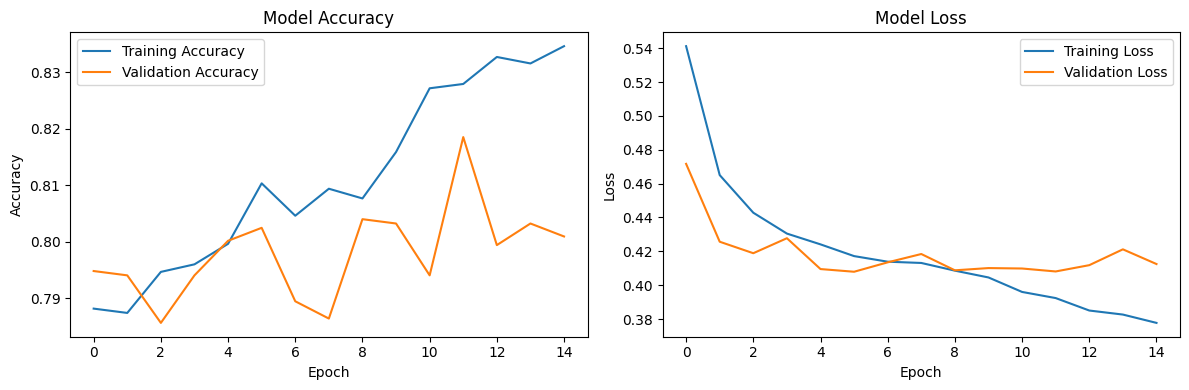

In [ ]:
# Assuming you have trained your model and have a `history` object
# after fitting the model

import matplotlib.pyplot as plt

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1 = f1_score(y_val_labels, y_pred_labels, average='weighted')
precision = precision_score(y_val_labels, y_pred_labels, average='weighted')
recall = recall_score(y_val_labels, y_pred_labels, average='weighted')

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(report)

F1 Score: 0.7941207608212276
Precision: 0.789484581940889
Recall: 0.8009188361408882
{'Hate': {'precision': 0.8593894542090657, 'recall': 0.8958534233365477, 'f1-score': 0.8772426817752597, 'support': 1037}, 'Not Hate': {'precision': 0.52, 'recall': 0.4349442379182156, 'f1-score': 0.4736842105263159, 'support': 269}, 'accuracy': 0.8009188361408882, 'macro avg': {'precision': 0.6896947271045328, 'recall': 0.6653988306273817, 'f1-score': 0.6754634461507878, 'support': 1306}, 'weighted avg': {'precision': 0.789484581940889, 'recall': 0.8009188361408882, 'f1-score': 0.7941207608212276, 'support': 1306}}


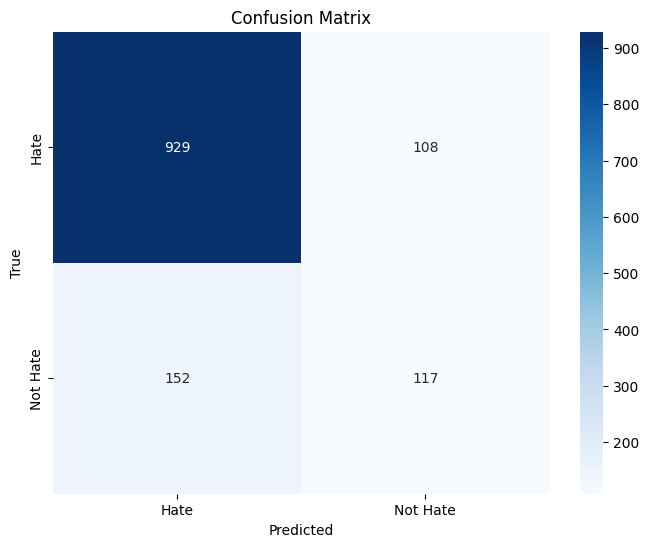

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_labels, y_pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Testing on Unseen Data

In [ ]:
vv= pd.read_csv('/content/drive/MyDrive/HateSpeech/Tracks Participated/ICON 2023/test_label1.csv')
vv
# vv = vv.rename(columns={'image_name' : 'unique_id', 'sentence' : 'text'})
# vv.to_csv('/content/drive/MyDrive/Colab Notebooks/MULTILATE/test.csv', index=False)

,id,text,language,key
0,1,"""who's this tweet about"" bitch it's about you ...",english,question_1
1,2,#AlkaLamba should’ve used her slippers to slap...,english,question_1
2,3,#CoronaVillains #COVIDIDIOT #COVID2019 is a...,english,question_1
3,4,"(Acts 29:19994) LIKE the female ""governors"" of...",english,question_1
4,5,***Let us celebrate “secular” as a beautiful w...,english,question_1
...,...,...,...,...
3753,3754,😂😂😂 ஊம்பு,tamil,question_1
3754,3755,"😄 தமிழ் தெரிஞ்சவன்""தான் உங்கொம்மால குண்டி அடிக...",tamil,question_1
3755,3756,😅😅😂😂 நீ தான் பங் அவனோலுக்கு கரெக்டா ஆன ஆளு.. 😎...,tamil,question_1
3756,3757,😺✏ — ஆமாம் வேச ஆமாம் வேச அய்ம் ச்லீபின் அய்ம் ...,tamil,question_1


In [ ]:
vv = vv[vv['language'] == 'english']
vv

,id,text,language,key
0,1,"""who's this tweet about"" bitch it's about you ...",english,question_1
1,2,#AlkaLamba should’ve used her slippers to slap...,english,question_1
2,3,#CoronaVillains #COVIDIDIOT #COVID2019 is a...,english,question_1
3,4,"(Acts 29:19994) LIKE the female ""governors"" of...",english,question_1
4,5,***Let us celebrate “secular” as a beautiful w...,english,question_1
...,...,...,...,...
1102,1103,you should be tired of not having any kind of ...,english,question_1
1103,1104,“The limits of tyrants are prescribed by the e...,english,question_1
1104,1105,♋️🦀 like wtf my symbol is 69 and I’m a crab an...,english,question_1
1105,1106,"🇺🇸: marry a millionaire guy, divorce get half ...",english,question_1


In [ ]:
vv1=vv

In [ ]:
# Task 1
model = keras.models.load_model('/content/drive/MyDrive/HateSpeech/Tracks Participated/ICON 2023/English/CNN_BiLSTM_ICON_Task-3_English_Binary_Classification.h5')
# Task 2
# model = keras.models.load_model('/content/drive/MyDrive/HateSpeech/Tracks Participated/ICON 2023/English/CNN_BiLSTM_Multilate_2.1M_Token_69_binary_label.h5')

In [ ]:
# # Function to determine binary_label
# def determine_binary_label(label):
#     if 'sexist' in label.lower() or 'racist' in label.lower():
#         return 'hate'
#     else:
#         return 'not_hate'

# # Apply the function to create the new column
# vv['binary_label'] = vv['label'].apply(determine_binary_label)

# # Switch the positions of 'binary_label' and 'label' columns
# # df1 = df1[['binary_label', 'label'] + [col for col in df1.columns if col not in ['label', 'binary_label']]]
# vv = vv[['unique_id', 'text', 'binary_label', 'label']]
# vv

In [ ]:
# vv.to_csv('/content/drive/MyDrive/Colab Notebooks/MULTILATE/test.csv', index=False)

In [ ]:
## Word Pre-Processing ##
import nltk
nltk.download('stopwords')
import string
import re
wpt = nltk.WordPunctTokenizer()
stop_words_init = nltk.corpus.stopwords.words('english')
stop_words = [i for i in stop_words_init if i not in ('not','and','for')]
print(stop_words)
## Function to normalize text for pre-processing ##
def normalize_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text
## Apply the written function ##
vv['text'] = vv['text'].apply(lambda x: normalize_text(x))
processed_list = []
for j in vv['text']:
    process = j.replace('...','')
    processed_list.append(process)

vv = pd.DataFrame(processed_list)
vv.columns = ['text']
vv.head(n=5)
######## Textual Features for Embedding ###################
# max_len = 100
# max_features = 10000
# embed_size = 300
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(x_train)+list(x_test))
# x_train = tokenizer.texts_to_sequences(x_train)
# x_test= tokenizer.texts_to_sequences(x_test)
# x_train = pad_sequences(x_train, padding='post', maxlen=max_len)
# x_test = pad_sequences(x_test, padding='post', maxlen=max_len)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text
0,who s this tweet about bitch it s about you ...
1,alkalamba should’ve used her slippers to slap...
2,coronavillains covididiot is a do...
3,acts like the female governors of stat...
4,let us celebrate “secular” as a beautiful w...


In [ ]:
######## Textual Features for Embedding ###################

sequence = tokenizer.texts_to_sequences(vv.text)
sequence = pad_sequences(sequence, padding='post', maxlen=max_len)

In [ ]:
sequence = tokenizer.texts_to_sequences(vv['text']) # same tokenizer which is used on train data.
sequence = pad_sequences(sequence,padding='post', maxlen = max_len)

predictions = model.predict(sequence)
classes=np.argmax(predictions,axis=1)

35/35 [==============================] - 2s 52ms/step


In [ ]:
predictions

array([[9.69456881e-03, 9.90305424e-01],
       [3.29422718e-03, 9.96705830e-01],
       [3.26734222e-02, 9.67326581e-01],
       ...,
       [3.11103067e-04, 9.99688864e-01],
       [1.17396594e-04, 9.99882579e-01],
       [1.84503922e-04, 9.99815524e-01]], dtype=float32)

In [ ]:
# Assign label 0 if the left probability is higher, otherwise label 1
predictions = np.argmax(predictions, axis=1)
# predictions = 1 - predictions

# Display the resulting array of predictions
print(predictions)

[0 0 0 ... 0 0 0]


In [ ]:
ids = np.arange(1, 1108)
# Create a DataFrame with 'id' and 'value' columns
result_df = pd.DataFrame({'id': ids, 'value': predictions})
# result_df = pd.DataFrame({'value': predictions})
result_df

,id,value
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0
...,...,...
1102,1103,1
1103,1104,0
1104,1105,0
1105,1106,0


In [ ]:
# Save the DataFrame to a CSV file
result_df.to_csv('/content/drive/MyDrive/HateSpeech/Tracks Participated/ICON 2023/English/Task3_output_English.csv', index=False)

Similarly, the output for test_label3.csv is found by simply changing the path.

---